In [1]:
###Load packages 
import pandas as pd
import numpy as np
import itertools
import warnings 
import json
from IPython.display import clear_output
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

warnings.filterwarnings("ignore")

### Dispatch packages
from disabled_passenger_api import dispatch_data_loader
from add_location import add_ps_location
from fake_passenger import generate_fake_passenger
from my_azure_storage import * 
from generate_random_location import Generate_taxi_random_location
from dispatch_data_prepare import dispatch_data_preprocessing
from dispatch_taxi_passenger import *

In [2]:
def generate_ps_and_taxi(date, fake_num):
    #passenger api 데이터 받기
    passenger = dispatch_data_loader(date)
    #승객 자세한 위치 정보 부여
    passenger = add_ps_location(passenger)
    #택시 생성
    taxi = Generate_taxi_random_location("서울 대한민국", len(set(passenger["no"])))
    #dispatch를 하기위해 데이터 전처리
    passenger, taxi = dispatch_data_preprocessing(passenger, taxi)
    #fake data 생성
    passenger = generate_fake_passenger(passenger, fake_num)
    return passenger, taxi

100%|██████████| 661/661 [04:26<00:00,  2.48it/s]


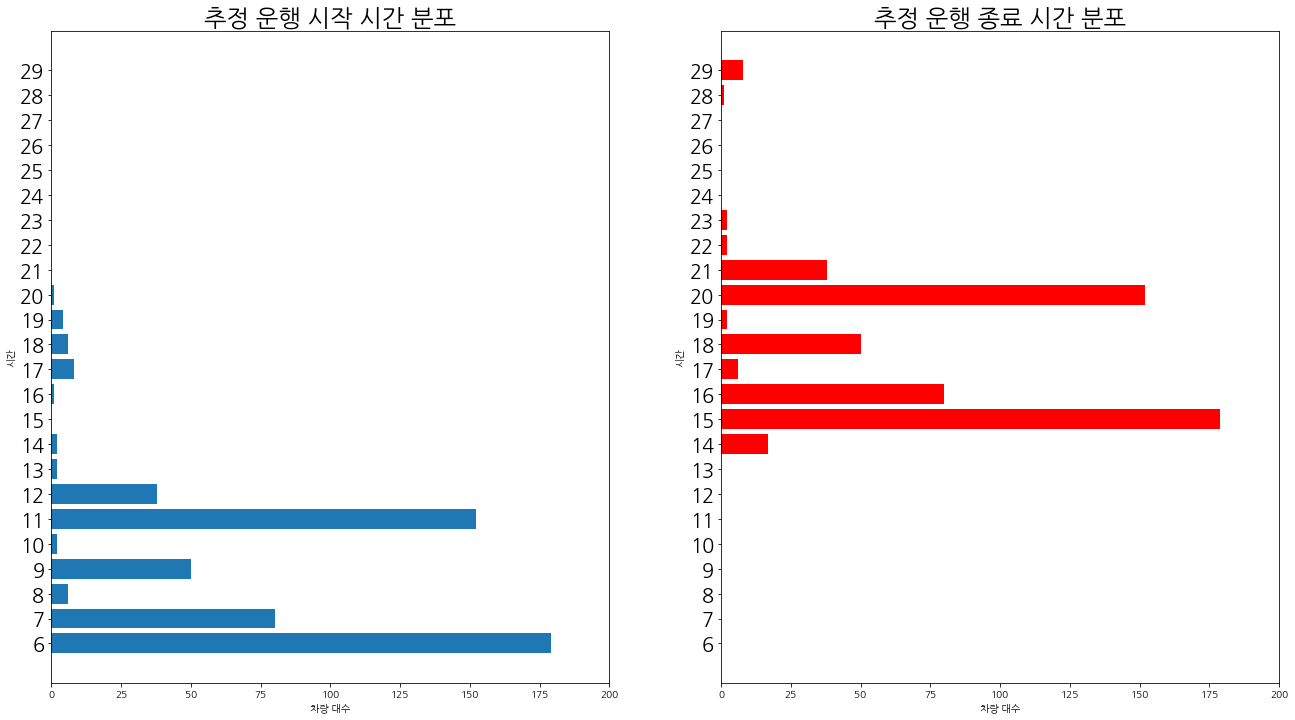

In [3]:
passenger_locations, taxi_locations = generate_ps_and_taxi("20220216", 0.001)

---

In [4]:
def dispatch_result_plot(t, waiting_ps, empty_tx, drive_tx, mode=None):
    plt.rcParams['axes.grid'] = True 
    plt.rcParams["figure.figsize"] = (24,16)

    plt.plot(t,waiting_ps, label = f"대기 승객 ({len(call_ps) + len(ps_remain)})")
    plt.plot(t,empty_tx, label = f"대기 차량 ({len(empty_taxi)})")
    plt.plot(t,drive_tx, label = f"운행 차량 ({len(driving_data)})")
    plt.legend(loc=2)
    if mode == "last":
        plt.savefig("./result_data/dispatch_result_360_1800.png")
    else:
        plt.show()

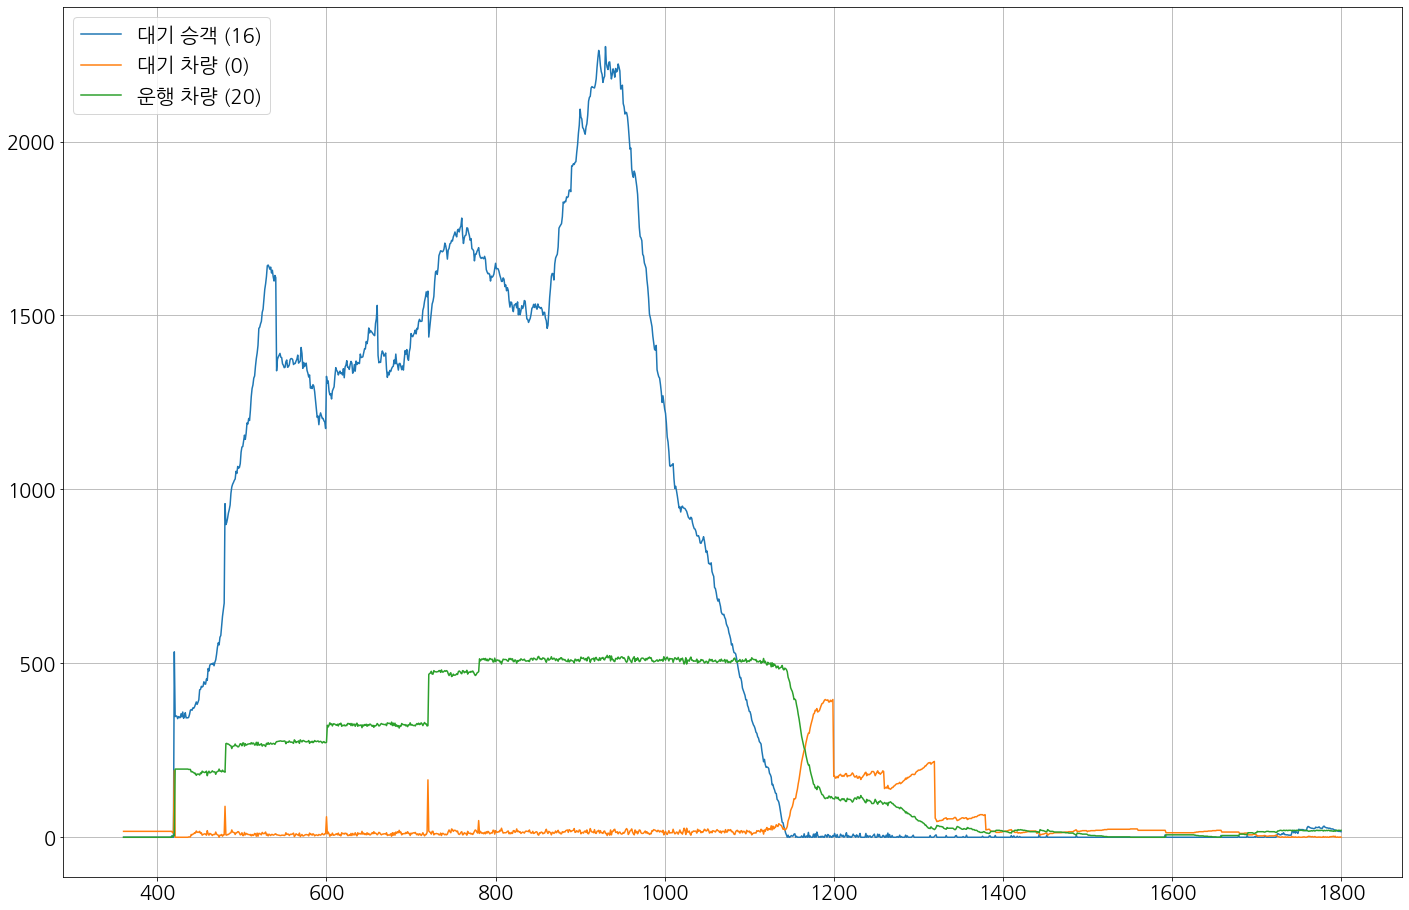

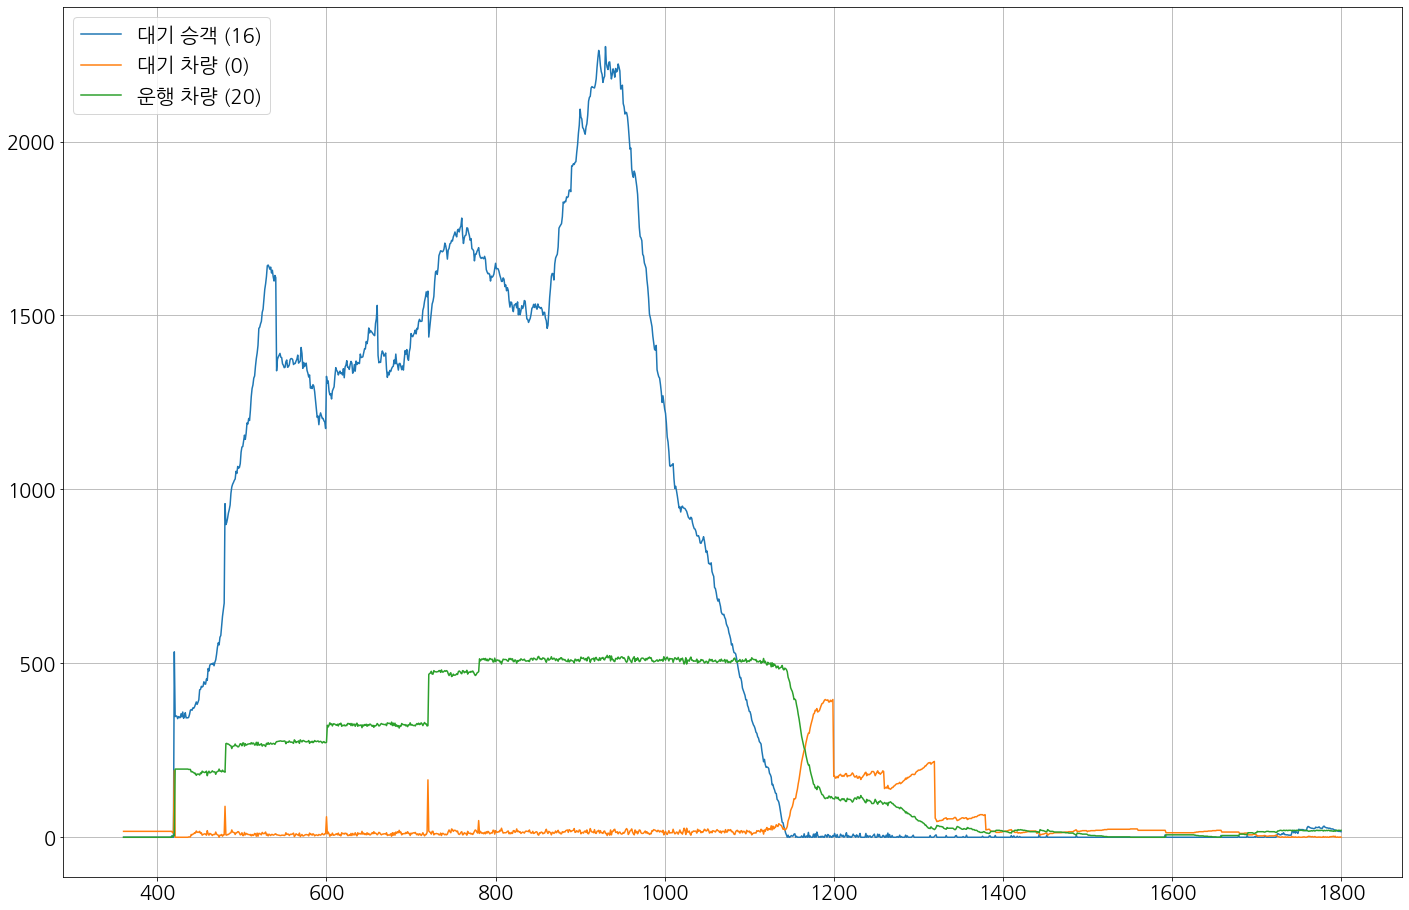

In [5]:
empty_taxi = pd.DataFrame()
driving_data = pd.DataFrame()
taxi_statistics_information = pd.DataFrame()
all_fail_data = pd.DataFrame()
trips = []
empty_inf = []
passenger_loc_information = []

###
waiting_ps = [] #대기 고객
fail_ps = [] #실패 고객
empty_tx = [] #배차 가능 차량 
drive_tx = [] #운행 중인 차량
t = [] #시간

###
ps_remain = []
for i in range(6*60, 30*60+1):
    ### Passenger, Taxi 추가 및 제거
    # - 운행 종료 택시 제거 및 360(운행시작시간)에서는 미실행
    if (i % 60 == 0) and (i != 360):
        empty_taxi = empty_taxi.loc[empty_taxi.work_end >= i]
    # - 60분(1시간) 마다 출근 택시 추가
    if i % 60 == 0:
        #운행 시작 택시
        start_taxi = taxi_locations.loc[taxi_locations.work_start == i]
        #배차 안된 택시
        empty_taxi = pd.concat([start_taxi, empty_taxi])
    # - 매 분 콜호출 고객 데이터 업데이트
    call_ps = passenger_locations.loc[passenger_locations.call_time == i]
    # - 빈 차량 정보 누적 업데이트(시각화를 위한 데이터) 
    empty_inf.append([i,empty_taxi])
    # - 콜 대기시간 60분 이상이면 콜실패로 콜 고객 데이터에서 제거
    # - 실패 데이터 시각화를 위한 누적 업데이트
    if len(ps_remain) > 0:
        fail_data = ps_remain.loc[ps_remain["dispatch_time"] >= 60]
        fail_data = fail_data[["call_time", "ps_loc_0"]]
        all_fail_data = pd.concat([all_fail_data, fail_data])
        
        ps_remain = ps_remain.loc[ps_remain["dispatch_time"] < 60]

    ### plot information
    waiting_ps.extend([len(call_ps) + len(ps_remain)])
    empty_tx.extend([len(empty_taxi)])
    drive_tx.extend([len(driving_data)])
    fail_ps.extend([len(all_fail_data)])
    t.extend([i])
    ### live plot
    clear_output(True)
    dispatch_result_plot(t, waiting_ps, empty_tx, drive_tx)
    
    ### Dispatch
    # - call_ps : 현시 콜 고객, ps_remain : 콜 대기 고객
    # 고객이 있을 때 또는 빈 차량이 있을때 -> 알고리즘 실행
    if (len(call_ps) + len(ps_remain) > 0) & (len(empty_taxi) > 0):
        # - ps_remain(콜 대기 고객)이 있을 때 실행
        if len(ps_remain) > 0:            
            trip, driving, ps_remain, tx_remain, taxi_statistics_inf, ps_locations_inf = match_taxi_ps(ps_remain, empty_taxi)
            taxi_statistics_information = pd.concat([taxi_statistics_information,taxi_statistics_inf])
            empty_taxi = tx_remain
            driving_data = pd.concat([driving_data, driving])
            passenger_loc_information.append(ps_locations_inf)
            trips.extend(trip)
            
            if len(ps_remain) > 0:
                ps_remain = pd.concat([ps_remain, call_ps])
        # - ps_remain(콜 대기 고객)이 없고, call_ps(콜 대기 고객)이 있을때 실행
        if (len(ps_remain) == 0) & (len(call_ps) > 0) & (len(empty_taxi) > 0):
            trip, driving, ps_remain, tx_remain, taxi_statistics_inf, ps_locations_inf = match_taxi_ps(call_ps, empty_taxi)
            empty_taxi = tx_remain
            driving_data = pd.concat([driving_data, driving])
            taxi_statistics_information = pd.concat([taxi_statistics_information,taxi_statistics_inf])
            passenger_loc_information.append(ps_locations_inf)
            trips.extend(trip)
    
    ### Driving taxi, Empty taxi 전환 
    # - driving_data(운행 중인 차량)에서 고객이 내린 차량은 빈 택시로 전환
    if len(driving_data) > 0:
        #목적지까지 운행완료한 택시
        drive_end = driving_data.loc[driving_data["end_time"] <= i]
        drive_end = drive_end[["no","cartype","work_start","work_end","board_status","tx_loc"]]
        #운행 중인 택시
        driving_data = driving_data.loc[driving_data["end_time"] > i]
        #목적지까지 운행완료한 택시 빈 택시에 추가
        empty_taxi = pd.concat([empty_taxi ,drive_end])
        
### Save result plot
dispatch_result_plot(t, waiting_ps, empty_tx, drive_tx, mode="last")

### Passenger_information, Taxi_information
# - passenger_information
ps_loc_inf = pd.concat(passenger_loc_information)
ps_loc_inf = [{"path":[i[1]["loc"].x, i[1]["loc"].y], "timestamp":i[1]["time"]} for i in ps_loc_inf.iterrows()]  
# - empty_information
stop_taxi = pd.concat(list(map(lambda data: stop_taxi_inf(data), empty_inf)))
empty_inf = list(map(lambda data : generate_taxi_pull_over_inf(data[1]) ,stop_taxi.groupby("no")))
empty_inf = list(itertools.chain(*empty_inf))
# - Generate Passenger_information, Taxi_information 
ps_final_inf, taxi_final_inf = generate_drive_inf(taxi_locations, taxi_statistics_information)
# - fail passenger inf을 기존 승객 데이터에 추가
for i in ps_loc_inf:
    i.update({"fail":0})

ps_loc_inf.extend(list(map(lambda data: {"path": [data[1]["ps_loc_0"].x, data[1]["ps_loc_0"].y], "timestamp": [data[1]["call_time"], data[1]["call_time"] + 60], "fail":1} ,all_fail_data.iterrows())))

- layer information : 차량 트립, 빈 택시, 호출 승객

In [6]:
data_ct = connect_container("data")

### Layer information
blob_uploader(json.dumps(trips), "data", "trips")
blob_uploader(json.dumps(empty_inf), "data", "empty_taxi")
blob_uploader(json.dumps(ps_loc_inf), "data", "waiting_passenger")

- text information : 대기 승객, 대기 차량, 운전 중인 차량, 호출 실패 누적 고객 수

In [7]:
dispatch_inf = dict()
dispatch_inf["waiting_passenger_num"] = waiting_ps
dispatch_inf['empty_taxi_num'] = empty_tx
dispatch_inf['driving_taxi_num'] = drive_tx
dispatch_inf['fail_passenger_cumsum'] = fail_ps

In [8]:
blob_uploader(json.dumps(dispatch_inf), "data", "dispatch_inf")

---

### Report 

- 시간대 별 실패 승객, 총 승객 비교 시각화

In [6]:
bins = [i*60 for i in range(6,31)]
labels = [f"{i}" for i in range(6,30)]

fail_passenger_distribution = pd.DataFrame(pd.cut(all_fail_data["call_time"], bins = bins, labels = labels).value_counts(sort=False)).reset_index()
call_passenger_distribution = pd.DataFrame(pd.cut(passenger_locations["call_time"], bins = bins, labels = labels).value_counts(sort=False)).reset_index()

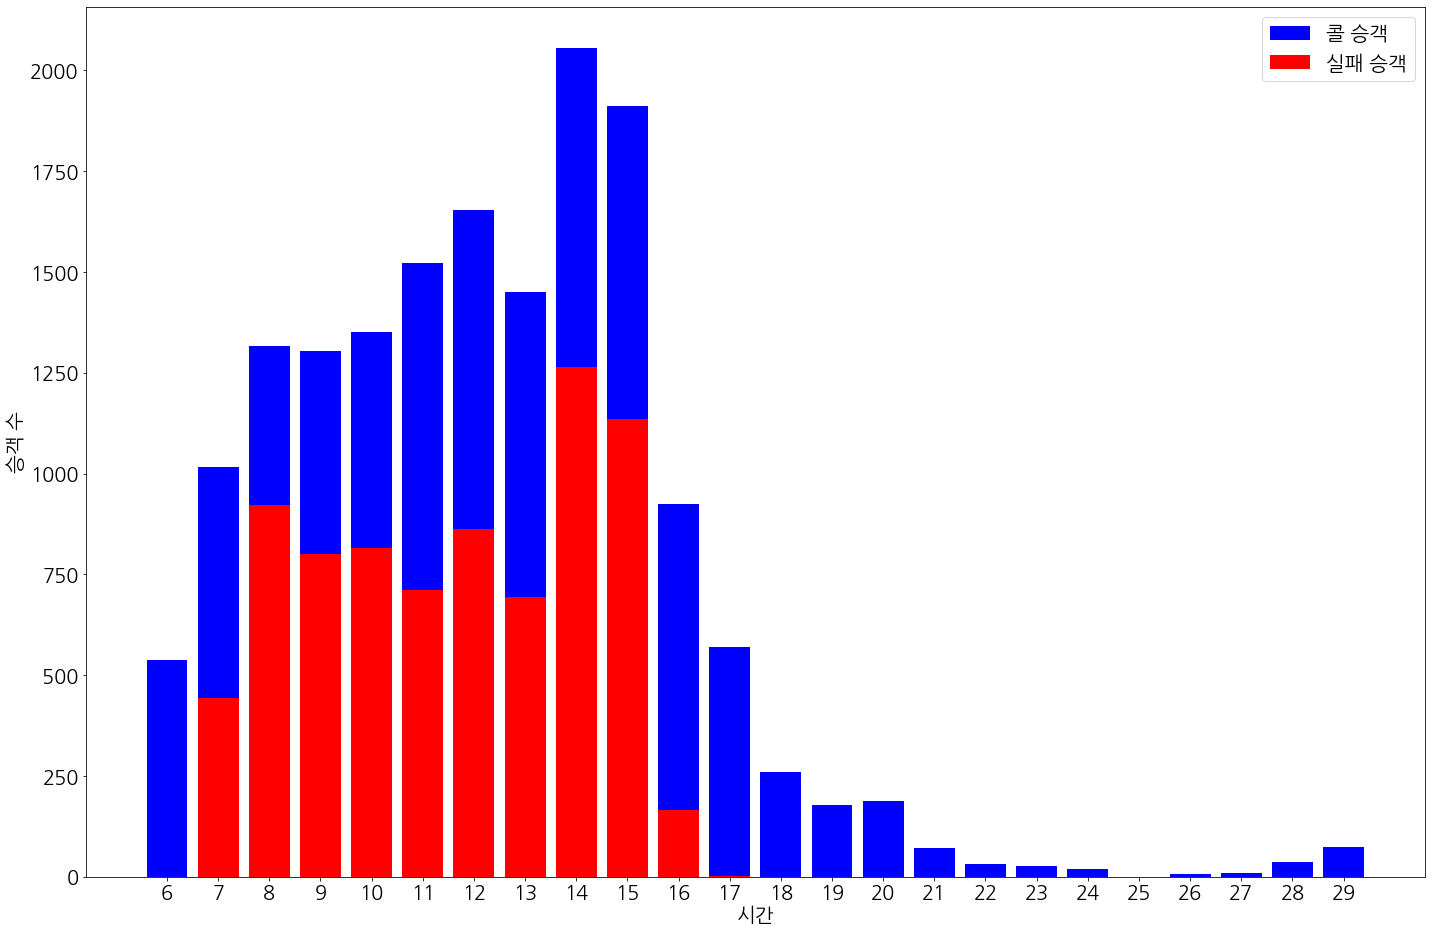

In [12]:
plt.bar(call_passenger_distribution["index"], call_passenger_distribution["call_time"], color='blue')
plt.bar(fail_passenger_distribution["index"], fail_passenger_distribution["call_time"], color="red")
plt.xlabel("시간")
plt.ylabel("승객 수")
plt.legend(["콜 승객", "실패 승객"])
plt.grid(False)

In [21]:
fail_distribution = pd.DataFrame(pd.cut(all_fail_data["call_time"], bins = bins, labels = labels).value_counts(sort=False)).T
call_distribution = pd.DataFrame(pd.cut(passenger_locations["call_time"], bins = bins, labels = labels).value_counts(sort=False)).T

In [35]:
fail_distribution_summary = pd.concat([fail_distribution, call_distribution])
fail_distribution_summary.index = ["실패 승객", "총 승객"]
fail_distribution_summary.columns = [f"{i}시" for i in fail_distribution_summary.columns]
fail_distribution_summary

,6시,7시,8시,9시,10시,11시,12시,13시,14시,15시,...,20시,21시,22시,23시,24시,25시,26시,27시,28시,29시
실패 승객,0,443,921,801,815,711,862,694,1265,1135,...,0,0,0,0,0,0,0,0,0,0
총 승객,537,1015,1316,1305,1351,1523,1654,1450,2054,1912,...,189,72,32,27,19,0,7,9,36,74


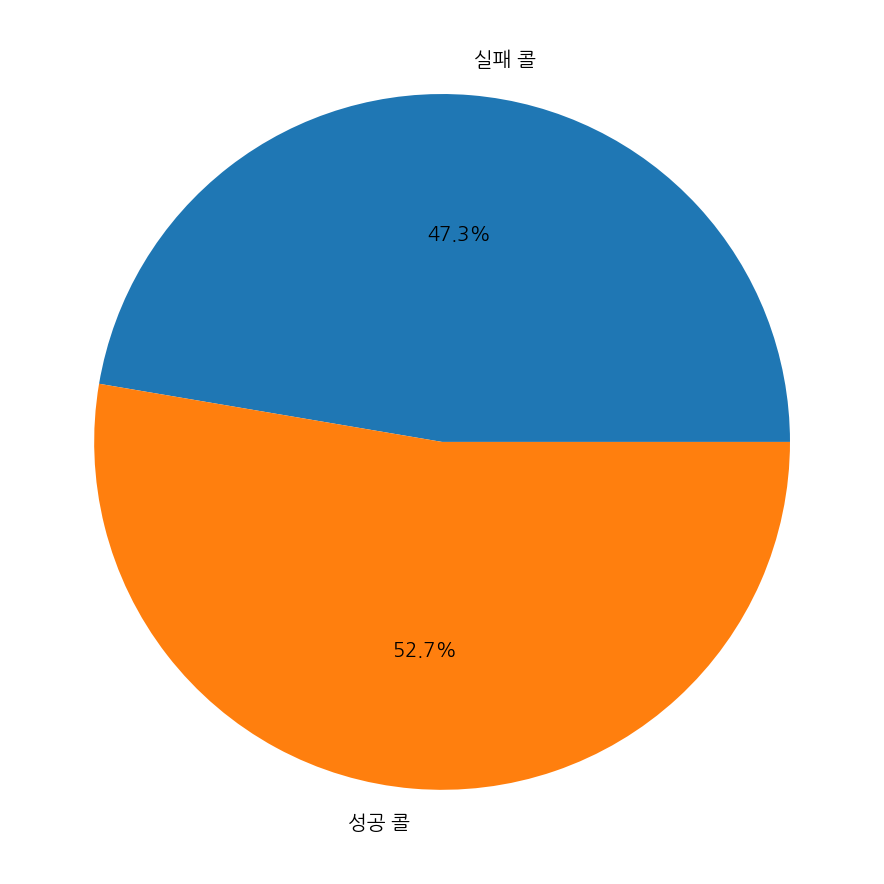

In [16]:
plt.pie([len(all_fail_data), len(passenger_locations) - len(all_fail_data)], labels=["실패 콜", "성공 콜"], autopct="%.1f%%")
plt.show()

--- 

- 콜 성공 후 대기 총 시간 (범주 별 bar)

In [49]:
### 콜 성공 후 대기 시간
wait_time = pd.DataFrame(np.ceil(ps_final_inf["wait_time"]).value_counts()).sort_index()
wait_time = wait_time.reset_index()

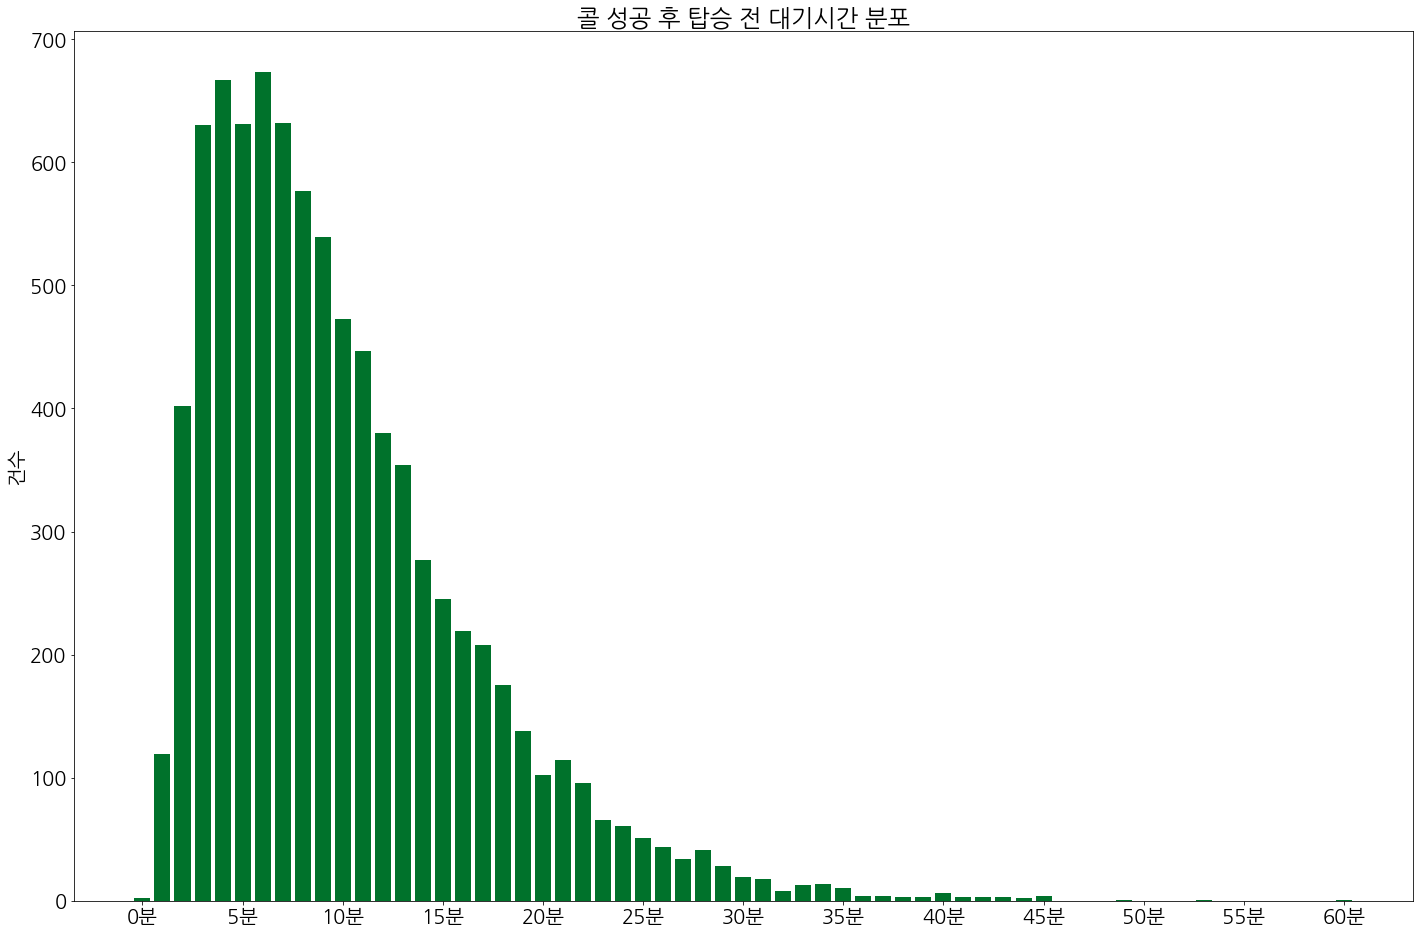

In [281]:
plt.bar(wait_time["index"], wait_time["wait_time"], color="#00722B")
plt.xticks(range(0,61,5), labels=[f"{i}분" for i in range(0,61,5)])
plt.title("콜 성공 후 탑승 전 대기시간 분포")
plt.ylabel("건수")
plt.grid(False)

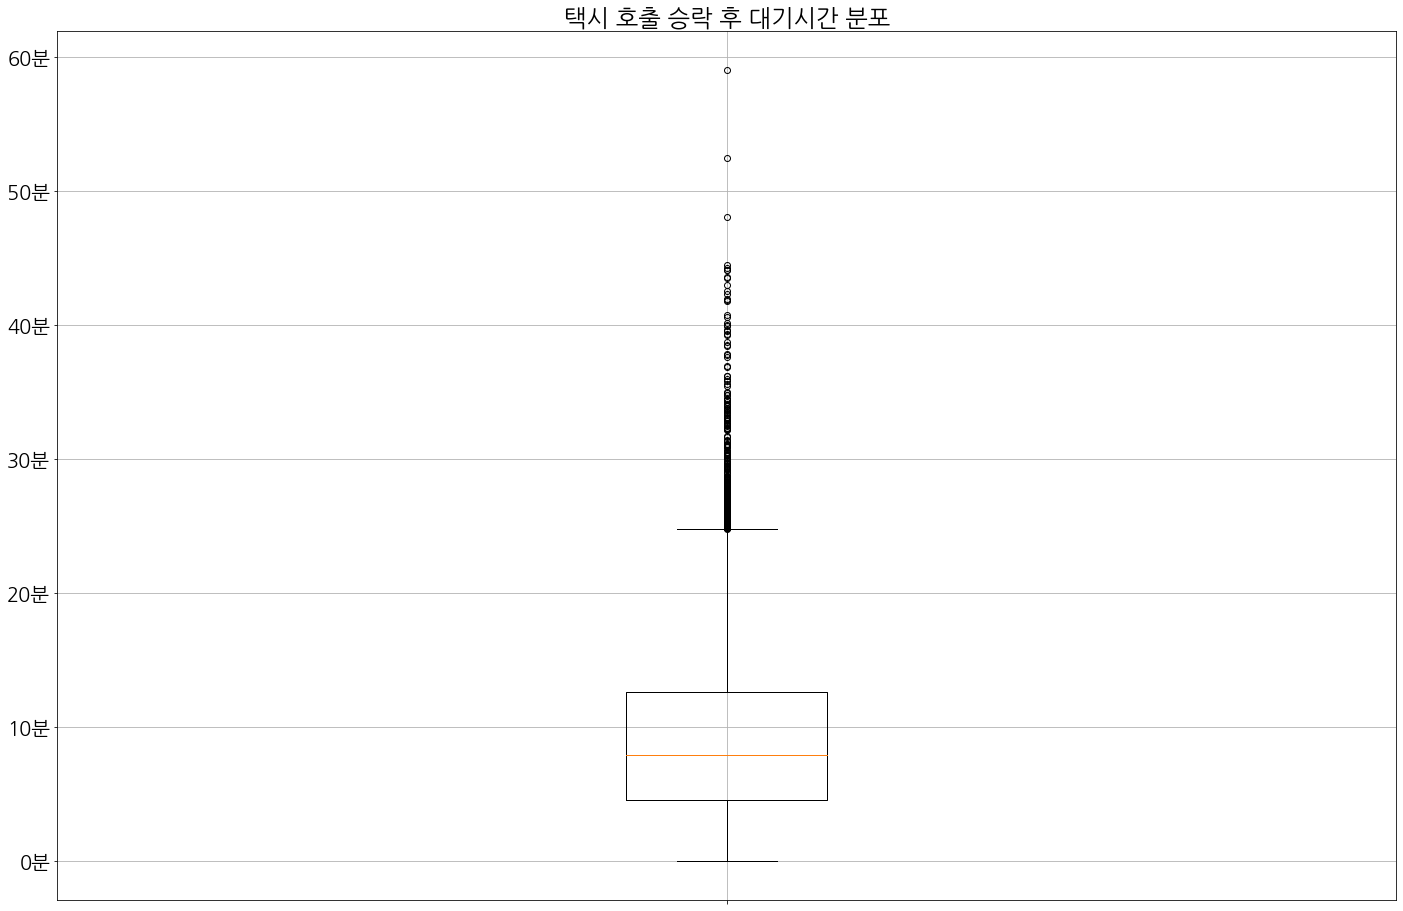

In [135]:
plt.boxplot(ps_final_inf["wait_time"])
plt.xticks([1] ,labels="")
plt.title("택시 호출 승락 후 대기시간 분포")
plt.yticks(range(0,61,10), labels = [f"{i}분" for i in range(0,61,10)])
plt.show()

In [136]:
wait_time_summary = pd.DataFrame(ps_final_inf["wait_time"].describe()).T[["min","max","25%","50%","75%"]]
wait_time_summary.index = [""]
wait_time_summary

,min,max,25%,50%,75%
,0.0,59.0,4.5,7.9,12.61


- 콜 성공까지 걸리는 총 시간 분포 (범주 별 bar)

In [138]:
### 콜 성공 후 대기 시간
dispatch_time = pd.DataFrame(np.ceil(ps_final_inf["dispatch_time"]).value_counts()).sort_index()
dispatch_time = dispatch_time.reset_index()

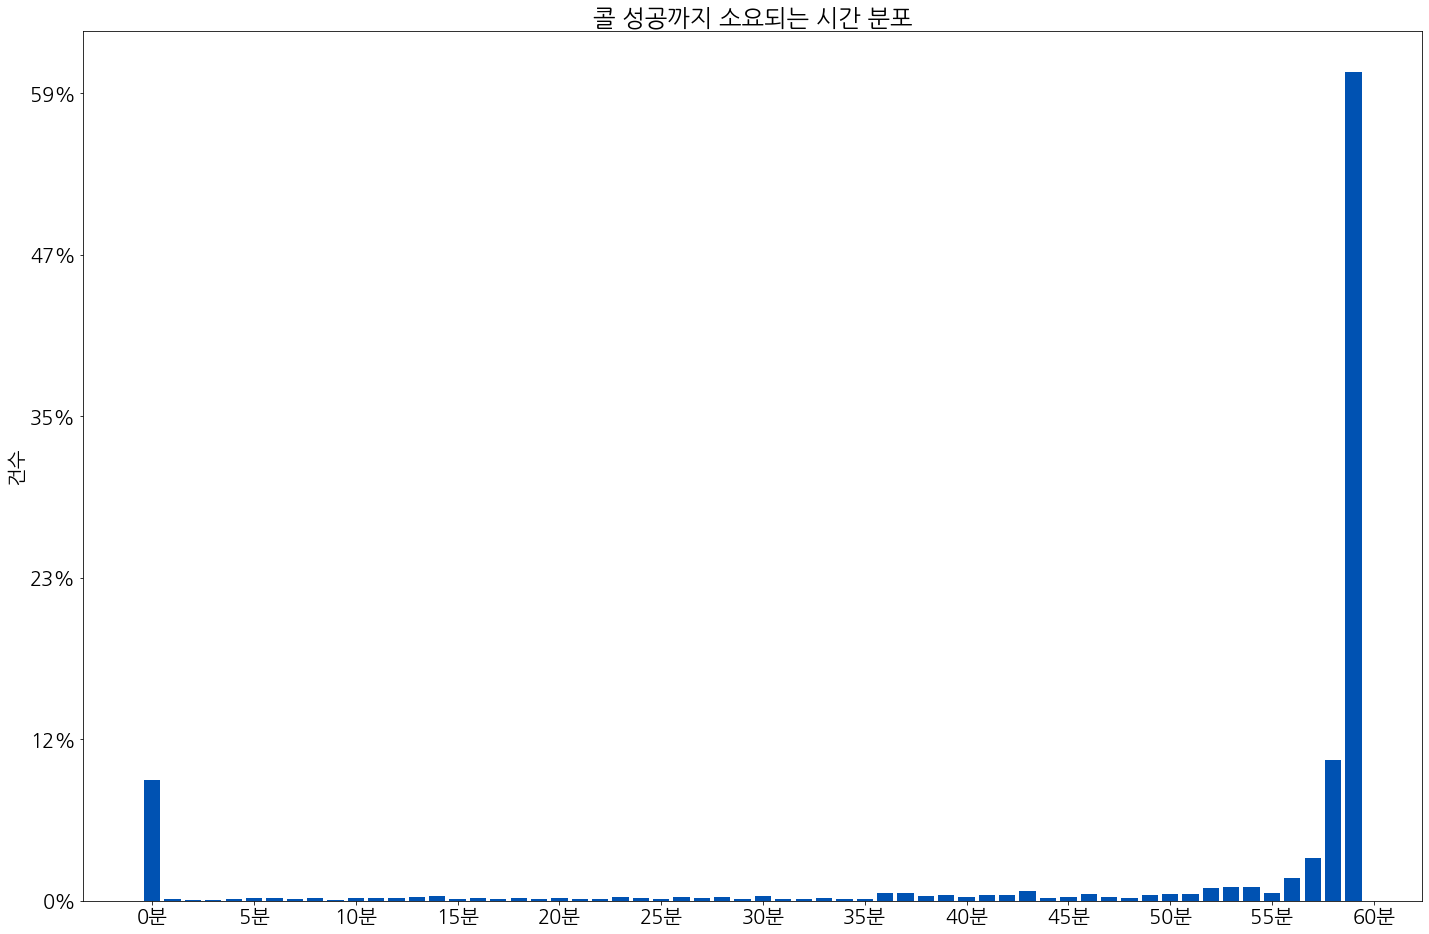

In [282]:
import matplotlib.ticker as mtick

plt.bar(dispatch_time["index"], dispatch_time["dispatch_time"], color="#0052B2")
plt.xticks(range(0,61,5), labels=[f"{i}분" for i in range(0,61,5)])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=len(trips)/2))
plt.title("콜 성공까지 소요되는 시간 분포")
plt.ylabel("건수")
plt.grid(False)

In [283]:
dispatch_time_summary = pd.DataFrame(ps_final_inf["dispatch_time"].describe()).T[["min","max","mean","25%","50%","75%"]]
dispatch_time_summary.index = [""]
dispatch_time_summary

,min,max,mean,25%,50%,75%
,0.0,59.0,49.929901,55.0,59.0,59.0


- 차량 별 운행 건수 분포 (bar)

In [174]:
# #차량 별 운행 건수 분포 
driving_count = pd.DataFrame(taxi_final_inf["drive_cnt"].value_counts()).sort_index().reset_index()

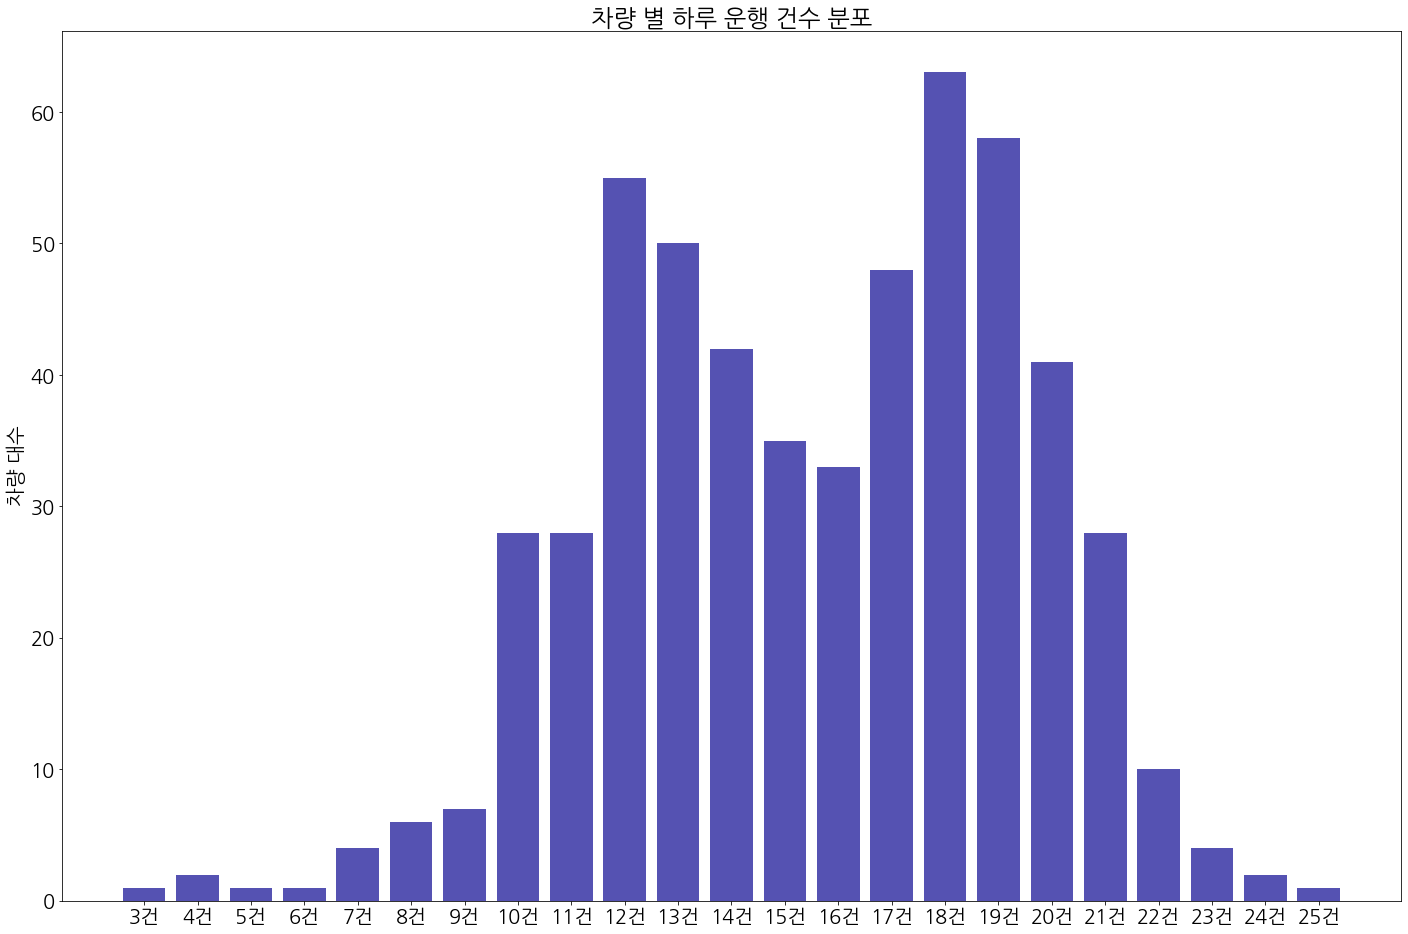

In [188]:
plt.bar(driving_count["index"], driving_count["drive_cnt"], color="#5552B2")
plt.xticks(range(int(min(driving_count["index"])), int(max(driving_count["index"])+1)), [f"{i}건" for i in range(int(min(driving_count["index"])), int(max(driving_count["index"])+1))])
plt.title("차량 별 하루 운행 건수 분포")
plt.ylabel("차량 대수")
plt.grid(False)

In [284]:
driving_count_summary = pd.DataFrame(driving_count["index"].describe()).T[["min","max","mean","25%","50%","75%"]]
driving_count_summary.index = [""]
driving_count_summary

,min,max,mean,25%,50%,75%
,3.0,25.0,14.0,8.5,14.0,19.5


- 차량 배차 후 고객한테 가는 총 시간

In [274]:
a =  taxi_final_inf[["total_to_ps_drive_time", "total_ps_drive_time"]]
a["total_drive_time"] = [i+j for i,j in zip(a["total_to_ps_drive_time"],a["total_ps_drive_time"])]

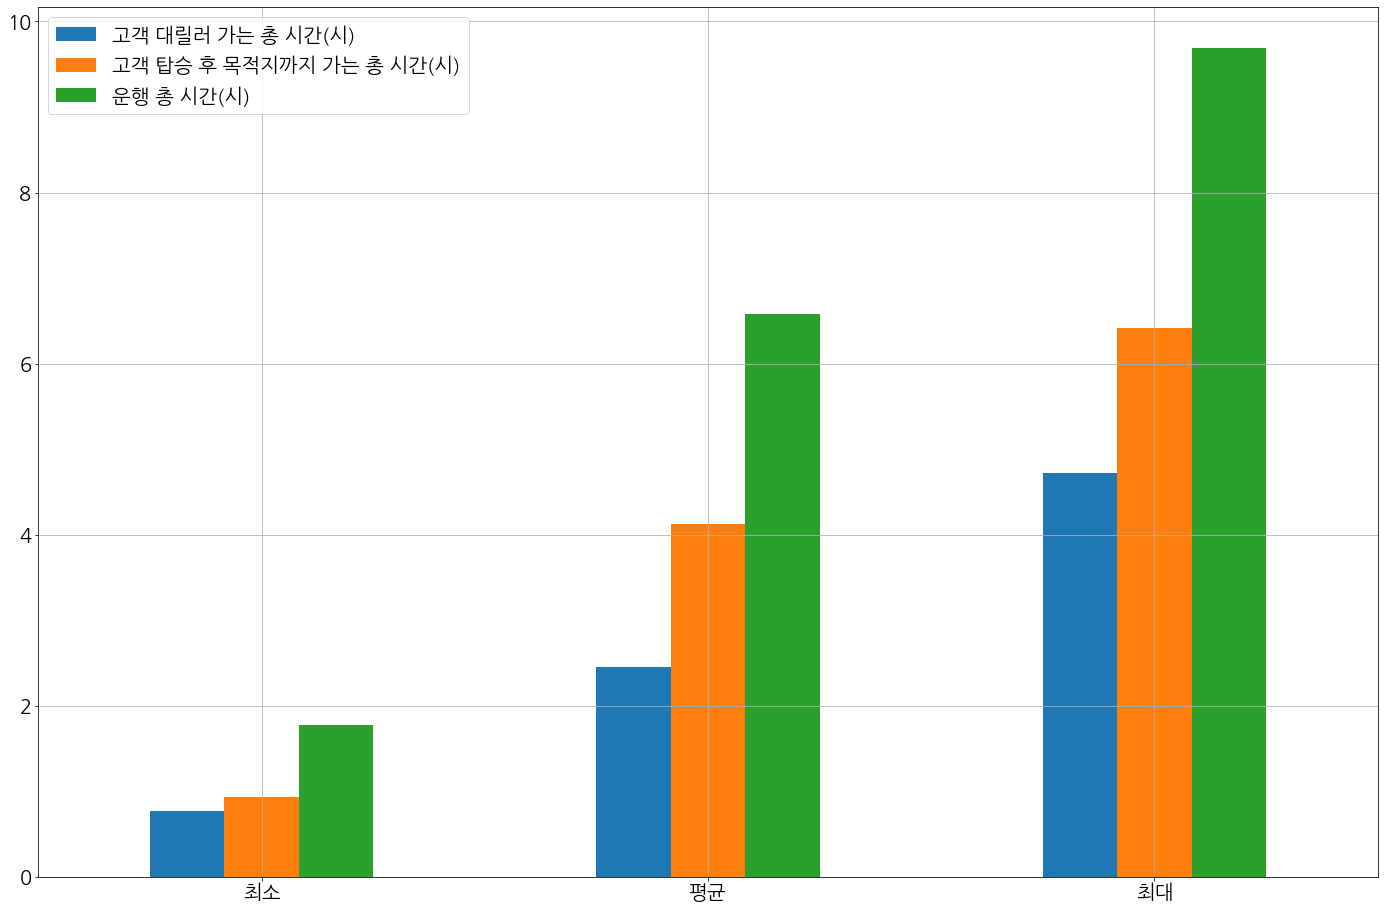

In [279]:
ad = a.describe().T[["min","mean","max"]].T
ad = ad/60
ad.index = ["최소", "평균", "최대"]
ad.columns = ["고객 대릴로 가는 총 시간(시)", "고객 탑승 후 목적지까지 가는 총 시간(시)", "운행 총 시간(시)"]

ad.plot(kind="bar", rot=0)
plt.show()

- 차랑 운행 총 거리

In [222]:
b =  taxi_final_inf[["total_to_ps_distance", "total_ps_distance"]]
b["total_drive_distance"] = [i+j for i,j in zip(b["total_to_ps_distance"],b["total_ps_distance"])]

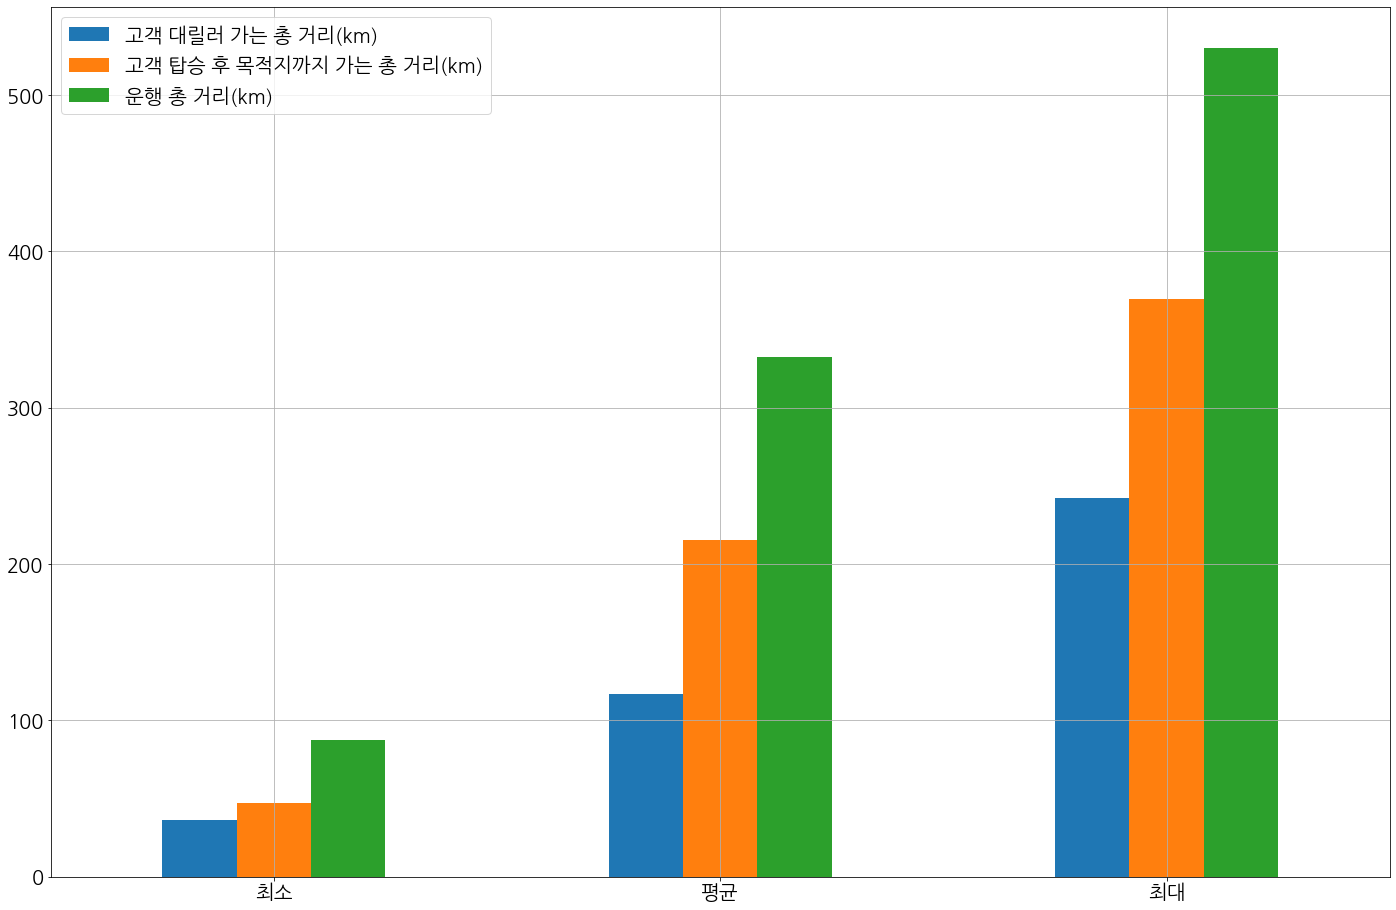

In [278]:
bd = b.describe().T[["min","mean","max"]].T
bd = bd/1000
bd.index = ["최소", "평균", "최대"]
bd.columns = ["고객 대릴러 가는 총 거리(km)", "고객 탑승 후 목적지까지 가는 총 거리(km)", "운행 총 거리(km)"]

bd.plot(kind="bar", rot=0)
plt.show()